In [1]:
import cmocean.cm as cmocean
import cosima_cookbook as cc
import glob
import gsw
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from dask.distributed import Client
from joblib import Parallel, delayed

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42043,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45431,Total threads: 2
Dashboard: /proxy/38365/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:36599,


In [3]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

start_time = '2150-01-01' 
end_time   = '2159-12-31'

lat_slice  = slice(-80,-59)

In [4]:
isobath_depth = 1000
# Load the isobath information
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)
# We are interested in the t-grid:
num_points = data['num_points_t']
distance_along_contour = data['distance_along_contour_t']
lon_along_contour = data['lon_along_contour_t']
lat_along_contour = data['lat_along_contour_t']

## Salt

In [5]:
salt_con = cc.querying.getvar(expt, 'salt', session, frequency = '1 monthly',
                              start_time = start_time, end_time = end_time)
salt_con = salt_con.sel(yt_ocean = lat_slice).sel(time=slice(start_time, end_time)).mean('time')                             
salt_con = salt_con.load()

2023-04-12 14:16:05,575 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-12 14:16:10,744 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [10]:
def get_salt_along_contour(ii):
    return salt_con.sel(xt_ocean=lon_along_contour[ii], method='nearest').sel(yt_ocean=lat_along_contour[ii], method='nearest').values

results = Parallel(n_jobs=-1)(delayed(get_salt_along_contour)(ii) for ii in range(num_points))

salt_along_contour = np.zeros((len(salt_con['st_ocean']), num_points))
for ii in range(num_points):
    salt_along_contour[:, ii] = results[ii]

salt_darray = xr.DataArray(salt_along_contour[:,:-1], name = 'salt', dims = ['st_ocean', 'lon_along_contour'],
                           coords = {'st_ocean':salt_con['st_ocean'], 'lon_along_contour':lon_along_contour[:-1]})

## temp

In [16]:
temp_con = cc.querying.getvar(expt, 'temp', session, frequency = '1 monthly',
                              start_time = start_time, end_time = end_time)
temp_con = temp_con.sel(yt_ocean = lat_slice).sel(time=slice(start_time, end_time)).mean('time')                             
temp_con = temp_con.load()

2023-04-12 14:18:10,493 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-12 14:18:11,544 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-12 14:18:11,546 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-12 14:18:12,023 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-12 14:18:12,047 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-04-12 14:18:31,271 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-04-12 14:18:32,755 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-04-12 14:18:47,793 - distributed.utils_perf - WARNING - full garbage collections took

In [20]:
def get_temp_along_contour(ii):
    return temp_con.sel(xt_ocean=lon_along_contour[ii], method='nearest').sel(yt_ocean=lat_along_contour[ii], method='nearest').values

results = Parallel(n_jobs=-1)(delayed(get_temp_along_contour)(ii) for ii in range(num_points))

temp_along_contour = np.zeros((len(temp_con['st_ocean']), num_points))
for ii in range(num_points):
    temp_along_contour[:, ii] = results[ii]

temp_darray = xr.DataArray(temp_along_contour[:,:-1], name = 'temp', dims = ['st_ocean', 'lon_along_contour'],
                           coords = {'st_ocean':salt_con['st_ocean'], 'lon_along_contour':lon_along_contour[:-1]})

# woa

In [51]:
salt_woa = xr.open_mfdataset(np.sort(glob.glob('/g/data/ik11/observations/woa18/woa18_A5B7_s*.nc')))
salt_woa = salt_woa['s_an'].mean('time').rename({'lat':'yt_ocean','lon':'xt_ocean'})

salt_woa['xt_ocean'] = xr.where(salt_woa['xt_ocean'] > 80, salt_woa['xt_ocean'] - 360, salt_woa['xt_ocean']).values

salt_woa = salt_woa.sortby('xt_ocean')

salt_woa = salt_woa.load()

def get_salt_along_contour(ii):
    return salt_woa.sel(xt_ocean=lon_along_contour[ii], method='nearest').sel(yt_ocean=lat_along_contour[ii], method='nearest').values

results = Parallel(n_jobs=-1)(delayed(get_salt_along_contour)(ii) for ii in range(num_points))

salt_woa_along_contour = np.zeros((len(salt_woa['depth']), num_points))
for ii in range(num_points):
    salt_woa_along_contour[:, ii] = results[ii]

salt_woa_darray = xr.DataArray(salt_woa_along_contour[:,:-1], name = 'salt', dims = ['depth', 'lon_along_contour'],
                               coords = {'depth':salt_woa['depth'], 'lon_along_contour':lon_along_contour[:-1]})

In [39]:
temp_woa = xr.open_mfdataset(np.sort(glob.glob('/g/data/ik11/observations/woa18/woa18_A5B7_t*.nc')))
temp_woa = temp_woa['t_an'].mean('time').rename({'lat':'yt_ocean','lon':'xt_ocean'})

temp_woa['xt_ocean'] = xr.where(temp_woa['xt_ocean'] > 80, temp_woa['xt_ocean'] - 360, temp_woa['xt_ocean']).values

temp_woa = temp_woa.sortby('xt_ocean')

temp_woa = temp_woa.load()

def get_salt_along_contour(ii):
    return temp_woa.sel(xt_ocean=lon_along_contour[ii], method='nearest').sel(yt_ocean=lat_along_contour[ii], method='nearest').values

results = Parallel(n_jobs=-1)(delayed(get_salt_along_contour)(ii) for ii in range(num_points))

temp_woa_along_contour = np.zeros((len(temp_woa['depth']), num_points))
for ii in range(num_points):
    temp_woa_along_contour[:, ii] = results[ii]

temp_woa_darray = xr.DataArray(temp_woa_along_contour[:,:-1], name = 'salt', dims = ['depth', 'lon_along_contour'],
                               coords = {'depth':temp_woa['depth'], 'lon_along_contour':lon_along_contour[:-1]})

In [ ]:
# Convert to conservative temperature
p = gsw.p_from_z(-salt_woa_darray['depth'], salt_woa_darray['lon_along_contour'])
SA = gsw.SA_from_SP(salt_woa_darray,p[-1,:],salt_woa_darray['lon_along_contour'],lat_along_contour[:-1])
CT = gsw.CT_from_t(SA,temp_woa_darray,p)

In [25]:
panel_name = ['a)', 'b)', 'c)', 'd)']
plt.rcParams['font.size'] = 18
plt.rcParams['axes.facecolor']  = 'white'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['savefig.dpi']  = 150
plt.rcParams['savefig.bbox'] = 'tight'

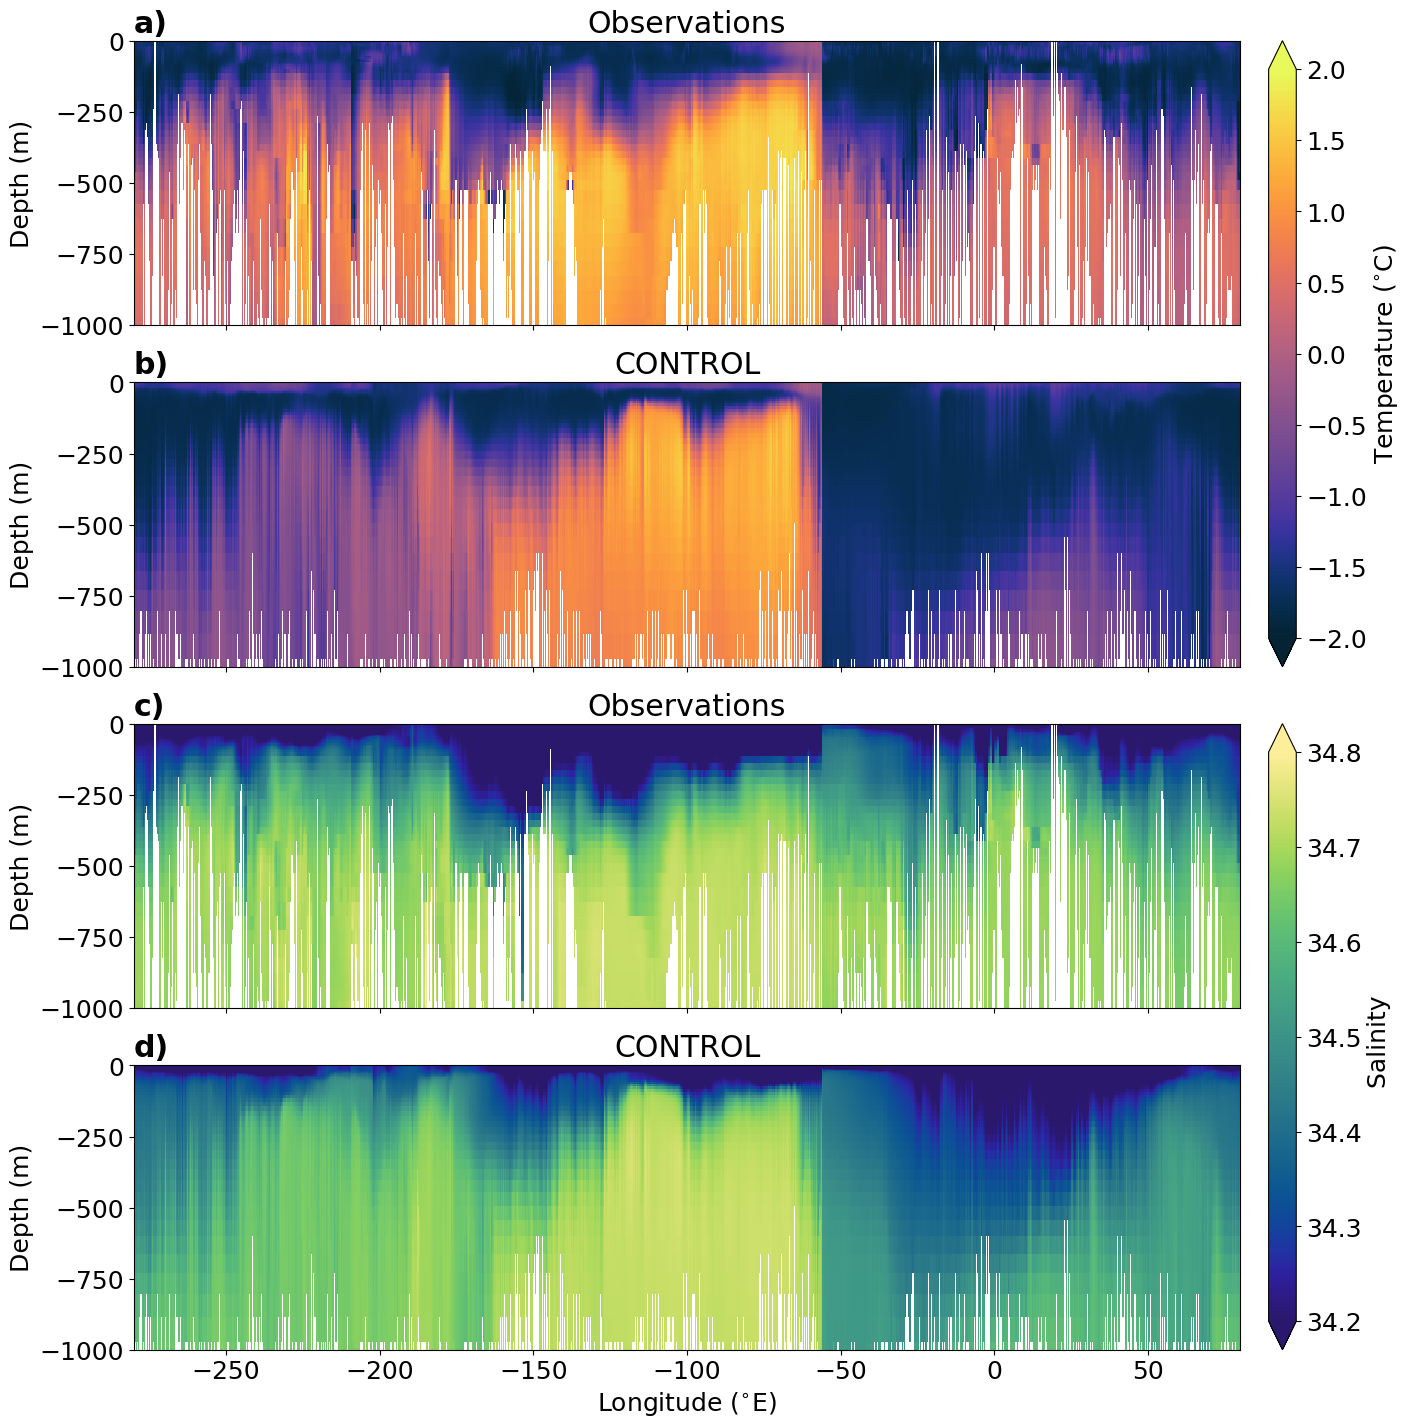

In [56]:
fig = plt.figure(figsize=(15, 17))
# Panel title
title_name = ['Observations', 'CONTROL', 'Observations', 'CONTROL']
# Subplots grid
gs  = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1], width_ratios=[1, 0.025], wspace=0.05)
    
for ii in range(4):
    if ii == 0:
        ax = fig.add_subplot(gs[ii])
        ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
        ax.set_xlim([-280, 80])
        ax.set_ylim([-1000, None])
        ax.set_title(title_name[ii])
        cf = ax.pcolormesh(CT['lon_along_contour'], -CT['depth'], CT, 
                           cmap=cmocean.thermal, vmin=-2, vmax=2) 
    elif ii == 1:
        ax = fig.add_subplot(gs[ii+1])
        ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
        ax.set_xlim([-280, 80])
        ax.set_ylim([-1000, None])
        ax.set_title(title_name[ii])
        cf = ax.pcolormesh(temp_darray['lon_along_contour'], -temp_darray['st_ocean'], temp_darray-273.15, 
                           cmap=cmocean.thermal, vmin=-2, vmax=2) 
    elif ii == 2:
        ax = fig.add_subplot(gs[ii+2])
        ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
        ax.set_xlim([-280, 80])
        ax.set_ylim([-1000, None])
        ax.set_title(title_name[ii])
        CF = ax.pcolormesh(salt_woa_darray['lon_along_contour'], -salt_woa_darray['depth'], salt_woa_darray, 
                           cmap=cmocean.haline, vmin=34.2, vmax=34.8) 
    elif ii == 3:
        # Salt, WIND-
        ax = fig.add_subplot(gs[ii+3])
        ax.set_title(panel_name[ii], loc='left', fontweight='bold')    
        ax.set_xlim([-280, 80])
        ax.set_ylim([-1000, None])
        ax.set_title(title_name[ii])
        CF = ax.pcolormesh(salt_darray['lon_along_contour'], -salt_darray['st_ocean'], salt_darray, 
                           cmap=cmocean.haline, vmin=34.2, vmax=34.8) 
        plt.xlabel('Longitude ($^{\circ}$E)')
        ax.set_ylim(-1000,None)
    plt.ylabel('Depth (m)')
    if ii < 3:
        plt.tick_params(labelbottom=False)
        
# Add colorbars
cbar_ax = fig.add_subplot(gs[0:2, -1])
cbar = plt.colorbar(cf, cax=cbar_ax, fraction=0.03, pad=0.01, extend='both')
cbar.set_label('Temperature ($^{\circ}$C)')
cbar_ax = fig.add_subplot(gs[2:, -1])
cbar = plt.colorbar(CF, cax=cbar_ax, fraction=0.03, pad=0.01, extend='both')
cbar.set_label('Salinity ')

# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'SuppFig2_1000m_TS_obs.png'
    plt.savefig(fig_name)